This is my final project for CSCA-5642 Introduction to Deep Learning at CU Boulder. In it, I will attempt to build a model that can generate believable song lyrics in style of one of my favorite rock bands—Pink Floyd.

The project is available in its entirety on my GitHub page at: https://github.com/giosofteng/pflg

Before we begin though, let us put all of our library imports in a single cell for improved readability:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Bidirectional, Dense, Dropout, Embedding, GRU, \
    Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import torch
from torch.utils.data import DataLoader
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments
from wordcloud import WordCloud

# use better formatting
pd.set_option('display.expand_frame_repr', False)

The dataset that we will use is available on Kaggle under the name “Pink Floyd Lyrics” by user João Robson.

Here is the link to it: https://www.kaggle.com/datasets/joaorobson/pink-floyd-lyrics

It contains lyrics from the band‘s 15 studio albums. Let us load and visualize the data:

In [2]:
data = pd.read_csv('pink_floyd_lyrics.csv')
print(f'\nSAMPLE DATA:\n{data.head()}\n')
print('DATA INFO:\n')
data.info()
print()


SAMPLE DATA:
                            album        song_title        year                                             lyrics
0  The Piper at the Gates of Dawn  Astronomy Domine  1967-08-05  "Moon in both [houses]..."...Scorpio, [Arabian...
1  The Piper at the Gates of Dawn       Lucifer Sam  1967-08-05  Lucifer Sam, siam cat\nAlways sitting by your ...
2  The Piper at the Gates of Dawn    Matilda Mother  1967-08-05  There was a king who ruled the land\nHis Majes...
3  The Piper at the Gates of Dawn           Flaming  1967-08-05  Alone in the clouds all blue\nLying on an eide...
4  The Piper at the Gates of Dawn     Pow R. Toc H.  1967-08-05  TCH TCH\nAHH (AHH)\nTCH TCH\nAHH AHH\nDoi doi\...

DATA INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   album       163 non-null    object
 1   song_title  163 non-null    object
 2   year        16

Great! Everything seems to be in order and we have plenty of data to work with.

Now, let us move on to cleaning our data. We can start by removing the unnecessary columns, only leaving the “lyrics”:

In [3]:
data = data.drop(columns=['album', 'song_title', 'year'])
data = data['lyrics']
print(f'\n{data.head()}\n')
data.info()
print()


0    "Moon in both [houses]..."...Scorpio, [Arabian...
1    Lucifer Sam, siam cat\nAlways sitting by your ...
2    There was a king who ruled the land\nHis Majes...
3    Alone in the clouds all blue\nLying on an eide...
4    TCH TCH\nAHH (AHH)\nTCH TCH\nAHH AHH\nDoi doi\...
Name: lyrics, dtype: object

<class 'pandas.core.series.Series'>
RangeIndex: 163 entries, 0 to 162
Series name: lyrics
Non-Null Count  Dtype 
--------------  ----- 
125 non-null    object
dtypes: object(1)
memory usage: 1.4+ KB



Much better! Still, we have plenty of work to do. Let us also dispose of all null rows:

In [4]:
data = data.dropna()
print()
data.info()
print()


<class 'pandas.core.series.Series'>
Index: 125 entries, 0 to 159
Series name: lyrics
Non-Null Count  Dtype 
--------------  ----- 
125 non-null    object
dtypes: object(1)
memory usage: 2.0+ KB



Next, you might have noticed that our lyrics contain hard-coded newline characters (“\n”). Let us replace those with empty spaces:

In [5]:
data = data.str.replace('\n', ' ', regex=False)
print(f'\n{data.head()}\n')


0    "Moon in both [houses]..."...Scorpio, [Arabian...
1    Lucifer Sam, siam cat Always sitting by your s...
2    There was a king who ruled the land His Majest...
3    Alone in the clouds all blue Lying on an eider...
4    TCH TCH AHH (AHH) TCH TCH AHH AHH Doi doi AHH ...
Name: lyrics, dtype: object



Let us next make all text lowercase and only leave the alphabetic characters:

In [6]:
data = data.str.replace(r'[^a-zA-Z\s]', '', regex=True).str.lower()
print(f'\n{data.head()}\n')


0    moon in both housesscorpio arabian skies libra...
1    lucifer sam siam cat always sitting by your si...
2    there was a king who ruled the land his majest...
3    alone in the clouds all blue lying on an eider...
4    tch tch ahh ahh tch tch ahh ahh doi doi ahh ah...
Name: lyrics, dtype: object



Looks much better! Let us also conduct some EDA to get a better view of our data:


Mean song length: 141 words
Median song length: 137 words
Minimum song length: 5 words
Maximum song length: 419 words



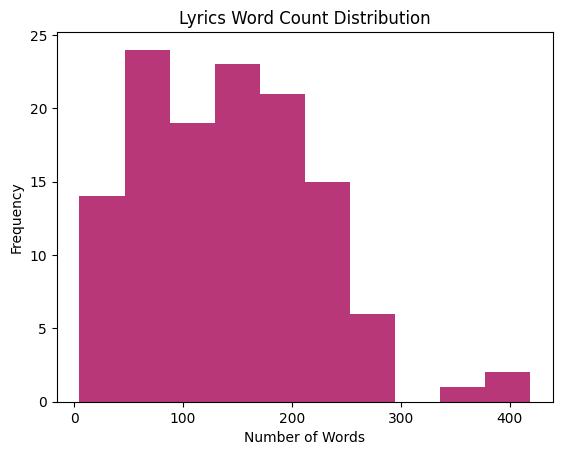

In [7]:
# word counts for each song
word_counts = data.str.split().apply(len)
# basic statistics
print(f'\nMean song length: {round(word_counts.mean())} words')
print(f'Median song length: {round(word_counts.median())} words')
print(f'Minimum song length: {round(word_counts.min())} words')
print(f'Maximum song length: {round(word_counts.max())} words\n')

plt.hist(word_counts, color=plt.cm.magma(0.5))
plt.title('Lyrics Word Count Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()
print()

It seems like, on average, our songs are ~140 words long. Useful to know! Let us also visualize the most common words using a word cloud:

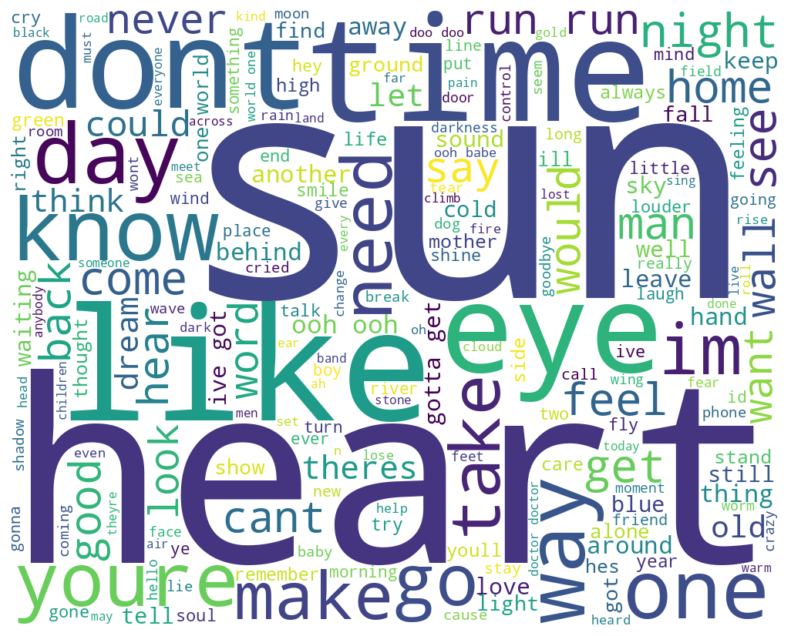

In [8]:
# all lyrics as a single string
all_lyrics = ' '.join(data)
# words to exclude
stopwords = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 
    'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 
    'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 
    'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 
    'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 
    'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 
    'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 
    'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 
    'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now'
]

wordcloud = WordCloud(
    stopwords=stopwords, background_color='white', width=1000, height=800).generate(all_lyrics)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
print()
plt.show()
print()

With this behind us, we can move on to text tokenization:

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)
# convert text to integer sequences based on tokenizer word index
sequences = tokenizer.texts_to_sequences(data)
# make sequences same length by padding with end zeros--necessary for GRU and LSTM
padded_sequences = pad_sequences(sequences, padding='post')
print(f'\n{padded_sequences}\n')


[[ 206    7  398 ...    0    0    0]
 [ 903 1371 1372 ...    0    0    0]
 [  44   20    4 ...    0    0    0]
 ...
 [  18 1123   28 ...    0    0    0]
 [2919  171 2920 ...    0    0    0]
 [  18 2933    3 ...    0    0    0]]



We are now ready to start building the model!

Let us begin by implementing a simple GRU (Gated Recurrent Unit). This is a kind of recurrent neural network, meant to be used with sequential (e.g. text) data. Unlike regular RNNs, it is very effective at capturing dependencies over time by controlling the information flow via gating. The gates in question are UPDATE (a combination of INPUT and FORGET gates) and RESET, which determines how much data to forget.

In [10]:
# number of unique words
vocabulary_size = len(tokenizer.word_index) + 1

layer_input = Input(shape=(padded_sequences.shape[1] - 1,))
# convert sequences to word embeddings
layer_embedding = Embedding(input_dim=vocabulary_size, output_dim=100)(layer_input)
# capture sequential dependencies
layer_gru_1 = GRU(units=150, return_sequences=True)(layer_embedding)
layer_gru_2 = GRU(units=150, return_sequences=True)(layer_gru_1)
# reduce dimensionality
layer_dense = Dense(units=64, activation='relu')(layer_gru_2)
# predict next word in sequence
layer_output = Dense(units=vocabulary_size, activation='softmax')(layer_dense)

model = Model(inputs=layer_input, outputs=layer_output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 418)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 418, 100)       │       294,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 418, 150)       │       113,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 418, 150)       │       135,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 418, 64)        │         9,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 418, 2945)      │       191,425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 744,889 (2.84 MB)

 Trainable params: 744,889 (2.84 MB)

 Non-trainable params: 0 (0.00 B)

Looks correct! Let us now compile and train said model:

In [11]:
# input sequences--all words except last
X = padded_sequences[:, :-1]
# target sequences--all words except first
y = padded_sequences[:, 1:]
# one hot encoding
y = to_categorical(y, num_classes=vocabulary_size)

# save development time
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X, y, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 1.8790e-04 - loss: 7.9877 - val_accuracy: 0.5931 - val_loss: 7.9264
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6921 - loss: 7.8930 - val_accuracy: 0.5933 - val_loss: 7.7120
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6874 - loss: 7.6237 - val_accuracy: 0.5933 - val_loss: 7.3427
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6842 - loss: 7.1862 - val_accuracy: 0.5933 - val_loss: 6.9209
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6856 - loss: 6.7006 - val_accuracy: 0.5933 - val_loss: 6.5150
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6753 - loss: 6.2556 - val_accuracy: 0.5933 - val_loss: 6.0997
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6944 - loss: 5.7315 - val_accuracy: 0.5933 - val_loss: 5.6277
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6808 - loss: 5.2387 - val_accuracy: 0.5933 - val_loss: 5.1178
Epoc

So, our initial model has a training accuracy of ~70% and a validation accuracy of ~60%. Not too bad!

Let us now try a similar LSTM (Long Short-Term Memory) model. Although more computationally intensive, it can at times capture more patterns due to its dual memory setup:

In [12]:
# . . . previous code stays same
layer_lstm_1 = LSTM(units=150, return_sequences=True)(layer_embedding)
layer_lstm_2 = LSTM(units=150, return_sequences=True)(layer_lstm_1)
layer_dense = Dense(units=64, activation='relu')(layer_lstm_2)
# following code stays same:
layer_output = Dense(units=vocabulary_size, activation='softmax')(layer_dense)

model = Model(inputs=layer_input, outputs=layer_output)
model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X, y, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 418)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 418, 100)       │       294,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 418, 150)       │       150,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 418, 150)       │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 418, 64)        │         9,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 418, 2945)      │       191,425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 826,789 (3.15 MB)

 Trainable params: 826,789 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 3.5486e-04 - loss: 7.9551 - val_accuracy: 0.5932 - val_loss: 7.7950
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6755 - loss: 7.7342 - val_accuracy: 0.5933 - val_loss: 7.5475
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6786 - loss: 7.4432 - val_accuracy: 0.5933 - val_loss: 7.2448
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6813 - loss: 7.0894 - val_accuracy: 0.5933 - val_loss: 6.8847
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6799 - loss: 6.6787 - val_accuracy: 0.5933 - val_loss: 6.4647
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6854 - loss: 6.1940 - val_accuracy: 0.5933 - val_loss: 5.9753
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6805 - loss: 5.6498 - val_accuracy: 0.5933 - val_loss: 5.4303
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6895 - loss: 5.0180 - val_accuracy: 0.5933 - val_loss: 4.8603
Epoc

No real improvement! Let us try a more complex LSTM next:

In [13]:
# . . . input layer stays same
layer_embedding = Embedding(input_dim=vocabulary_size, output_dim=200)(layer_input)
# stacked Bidirectional LSTM layers with Dropout regularization
layer_lstm_1 = Bidirectional(
    LSTM(units=256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(layer_embedding)
layer_lstm_2 = Bidirectional(
    LSTM(units=256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(layer_lstm_1)
layer_lstm_3 = Bidirectional(
    LSTM(units=256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(layer_lstm_2)
# fully connected layer
layer_dense = Dense(units=128, activation='relu')(layer_lstm_3)
layer_dropout = Dropout(0.3)(layer_dense)
layer_output = Dense(units=vocabulary_size, activation='softmax')(layer_dropout)

# following code stays same:
model = Model(inputs=layer_input, outputs=layer_output)
model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X, y, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 418)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 418, 200)       │       589,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 418, 512)       │       935,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 418, 512)       │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 418, 512)       │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 418, 128)       │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 418, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 418, 2945)      │       379,905 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,120,329 (19.53 MB)

 Trainable params: 5,120,329 (19.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.0573 - loss: 7.9783 - val_accuracy: 0.5933 - val_loss: 7.6275
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.6811 - loss: 7.4505 - val_accuracy: 0.5933 - val_loss: 6.3193
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.6828 - loss: 6.0118 - val_accuracy: 0.5933 - val_loss: 4.8478
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.6769 - loss: 4.3644 - val_accuracy: 0.5933 - val_loss: 3.5821
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.6746 - loss: 3.0850 - val_accuracy: 0.5933 - val_loss: 3.9070
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.6825 - loss: 3.0794 - val_accuracy: 0.5933 - val_loss: 4.2432
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.6866 - loss: 3.1877 - val_accuracy: 0.5933 - val_loss: 4.1492
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.6946 - loss: 3.0134 - val_accuracy: 0.5933 - val_loss: 3.8713
Epoch 9/

Still no improvement!

For our final model, let us leverage transfer learning and fine-tune the GPT-2 model instead of building ours from scratch:

In [14]:
# load GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# make pad token same as EOS token
tokenizer.pad_token = tokenizer.eos_token
# load GPT-2 model
model = GPT2LMHeadModel.from_pretrained('gpt2')
# resize model's embedding layer to tokenizer's vocabulary size
model.resize_token_embeddings(len(tokenizer))
# freeze first 8 transformer layers for faster training
for parameter in model.transformer.h[:8].parameters():
    parameter.requires_grad = False

# to store input IDs (tokenized lyrics)
input_ids = []
# to store attention masks for each input
attention_masks = []
# process lyrics
for lyric in data.tolist():
    # tokenize each lyric, truncate or pad to 512 tokens, and add to lists
    encodings = tokenizer(lyric, truncation=True, padding='max_length', max_length=512)
    input_ids.append(torch.tensor(encodings['input_ids']))
    attention_masks.append(torch.tensor(encodings['attention_mask']))

# init dataset and DataLoader
train_data = [{"input_ids": input_ids[i], "attention_mask": attention_masks[i]}
              for i in range(len(input_ids))]
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True)

# init training arguments
training_arguments = TrainingArguments(
    # directory to save checkpoints
    output_dir='./gpt2-pink-floyd',
    overwrite_output_dir=True,
    # train for 5 epochs
    num_train_epochs=5,
    per_device_train_batch_size=8,
    # save checkpoint every 500 steps
    save_steps=500,
    # only keep last 2 checkpoints
    save_total_limit=2,
    # log always
    prediction_loss_only=False,
    # log every 10 steps
    logging_steps=10
)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
# set model to training mode
model.train()
# train model
for epoch in range(training_arguments.num_train_epochs):
    # print current epoch
    print(f'Epoch {epoch+1} of {training_arguments.num_train_epochs}')
    # track cumulative loss, correct prediction count, and processed token count for each epoch
    total_loss = 0
    correct_predictions = 0
    total_tokens = 0
    for batch in train_dataloader:
        # reset gradients for each batch
        optimizer.zero_grad()
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'],
                        labels=batch['input_ids'])
        loss = outputs.loss
        total_loss += loss.item()
        # calculate accuracy
        # detach logits to avoid gradient graph computation
        logits = outputs.logits.detach()
        # get predicted tokens--max logit value per token
        predictions = torch.argmax(logits, dim=-1)
        correct_predictions += (predictions == batch['input_ids']).sum().item()
        total_tokens += torch.numel(batch['input_ids'])
        # print loss for each batch
        print(f'Loss: {loss.item()}')
        # perform backpropagation
        loss.backward()
        # update model parameters with optimizer
        optimizer.step()
    # print epoch avg loss and accuracy
    avg_loss = total_loss / len(train_dataloader)
    accuracy = correct_predictions / total_tokens
    print(f'Epoch {epoch+1}\n\tAvg Loss: {avg_loss:.2f}, Accuracy: {accuracy:.2f}')

Epoch 1 of 5
Loss: 7.210514068603516
Loss: 2.090731382369995
Loss: 1.58804452419281
Loss: 1.8005958795547485
Loss: 1.2460559606552124
Loss: 2.105574369430542
Loss: 1.365838646888733
Loss: 1.7095082998275757
Loss: 1.212727665901184
Loss: 1.1579771041870117
Loss: 1.251814842224121
Loss: 1.765261173248291
Loss: 1.8017456531524658
Loss: 1.3865599632263184
Loss: 1.4858883619308472
Loss: 1.5760070085525513
Epoch 1
	Avg Loss: 1.92, Accuracy: 0.65
Epoch 2 of 5
Loss: 1.420782446861267
Loss: 0.8448207974433899
Loss: 1.344373345375061
Loss: 0.7287806868553162
Loss: 1.605802059173584
Loss: 1.3045159578323364
Loss: 1.4020967483520508
Loss: 0.9981737732887268
Loss: 1.2583684921264648
Loss: 1.5423320531845093
Loss: 1.3428095579147339
Loss: 1.6487679481506348
Loss: 0.8997473120689392
Loss: 1.1243805885314941
Loss: 0.8938829302787781
Loss: 1.0683444738388062
Epoch 2
	Avg Loss: 1.21, Accuracy: 0.70
Epoch 3 of 5
Loss: 0.8034293055534363
Loss: 1.4604265689849854
Loss: 0.9684655070304871
Loss: 1.2197340726

It seems that, even with transfer learning, we cannot get over 70% accuracy! Still, let us try to generate some lyrics and see how our model actually performs:

In [24]:
# text generation prompt
prompt = 'dark side of the moon'
# tokenize to be suitable input
inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True)

# generate lyrics
outputs = model.generate(
    inputs['input_ids'],
    attention_mask=inputs['attention_mask'],
    # max and min generated text length
    max_length=500,
    min_length=100,
    # generate 1 sequence; do not repeat tokens
    num_return_sequences=1,
    no_repeat_ngram_size=2,
    # helps with coherent text
    temperature=0.8,
    # only sample top 30 tokens for each position
    top_k=30,
    # control diversity with nucleus sampling
    top_p=0.9,
    # introduce randomness with sampling
    do_sample=True,
    # prevent padding issues
    pad_token_id=tokenizer.eos_token_id
)
# decode and print generated lyrics
generated_lyrics = tokenizer.decode(outputs[0], skip_special_tokens=True)

# print with line breaks
words = generated_lyrics.split()
n = len(prompt.split())
formatted_lyrics = ''
for i in range(0, len(words), n):
    formatted_lyrics += ' '.join(words[i:i + n]) + '\n'
print(formatted_lyrics)

dark side of the moon
a second world illuminations were
discovered in the form of
a tongue so strange it
was said to fit just
like a ribbon on the
front of an airplane and
theres a scroll with a
dream scroll hidden deep beneath
it a man found it
to be so precise in
his robes and revealed a
note with an unladen silence
elses the shape of his
question to the heavens a
vow was given the price
of freedom and a new
day was beckoning to his
majesty there were no silver
and steel in silver the
way the silent and troubled
silence that had unleashed the
flames of desire unleashed all
the power of light the
earth unleashed a vapor trail
the dark side flowed down
the valley of flame and
flowed and burned down all
sides



Well, those are certainly some lyrics! More like a lost Led Zeppelin demo than Pink Floyd, but, it seems to be the best that we can do for now!

So, let us summarize everything that we did. Our goal was to create a deep learning model that would generate believable song lyrics in style of Pink Floyd. We discovered a relevant dataset on Kaggle—one that required quite a bit of cleaning. Still, we managed to make it usable and, after performing some EDA on it, managed to tokenize it and ready it for model training. Our very first model was a simple GRU, which in retrospect, performed decently. We tried to improve the results by using a more complex LSTM model instead. However, we did not observe any real gains. We then added further complexity to our LSTM; however, the results were still unsatisfactory. Finally, we leveraged transfer learning and created a GPT-2 based model. Although we could not break above 70% accuracy, we did manage to generate vague, somewhat poetic text with it. With this in mind, I would not say that we succeeded completely; however, I do think that the model that we have is a useful first step. With more relevant input and training, it should perform much better. Not to mention, there are many additions and alterations that we could try in the future!